# Denoising Deep Learning for 20mm Depth Profiles
 

**Repository:** [Link to the Github Repository](https://github.com/TimArniko/ML-projects/blob/main/Deep%20Learning/Denoising%20Deep%20Learning.ipynb)

**Dataset**: My own dataset from a depth camera.

---

## 1. Problem Description

The dataset contains depth measurements from a sensor at a fixed distance of 20mm.  
Each record has:

- `timestamp`
- `angle_x_20mm`, `angle_y_20mm`
- `depth_values_20mm`: a vector of depth measurements along multiple rays

A first inspection shows that almost all depth profiles are very similar and “clean”: there are no obvious obstacles or sensor faults, and the values lie in a narrow range. This makes standard supervised tasks such as classification (“collision vs safe”) or real anomaly detection rather meaningless.

Instead, I use the dataset to train a denoising model:

> I artificially corrupt the clean depth profiles with realistic noise and train a deep neural network to reconstruct the original clean signal.

This is a common strategy when real sensor failures are rare: synthetic corruptions simulate
- random spikes (single faulty readings),
- dropouts (missing values),
- small offsets or drifts.

The project goals are:

1. Perform EDA to understand the statistics and variability of the clean depth profiles.
2. Define several types of synthetic noise that model plausible sensor degradation.
3. Train and compare different models for denoising / reconstruction:
   - a classical baseline filter (moving average),
   - a fully connected autoencoder,
   - a 1D convolutional autoencoder.
4. Evaluate reconstruction quality with numerical metrics (MSE, MAE) and visualise examples of clean vs. noisy vs. reconstructed signals.
5. Discuss the advantages and limitations of deep learning for this kind of sensor denoising.


## 2. Imports and Configuration

In [1]:
import os
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 3. Data Loading and Parsing

In [2]:
DATA_PATH = "Messreihe_demo1.csv"

df_raw = pd.read_csv(DATA_PATH)
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (249, 4)


,timestamp,angle_x_20mm,angle_y_20mm,depth_values_20mm
0,36131,86.976160,124.594380,"[79.2999979967135, 79.2999979967135, 79.299997..."
1,95976,86.976160,124.594380,"[79.2999979967135, 79.2999979967135, 79.299997..."
2,131883,87.096747,124.537648,"[79.39999799418729, 79.2999979967135, 79.29999..."
3,170289,86.933806,124.867205,"[79.39999799418729, 79.2999979967135, 79.29999..."
4,201206,87.085374,124.503887,"[79.39999799418729, 79.2999979967135, 79.29999..."


### 3.1 Parsing `depth_values_20mm`

count     249.000000
mean     5281.670683
std        11.665187
min      5245.000000
25%      5272.000000
50%      5283.000000
75%      5290.000000
max      5316.000000
Name: depth_values_20mm, dtype: float64


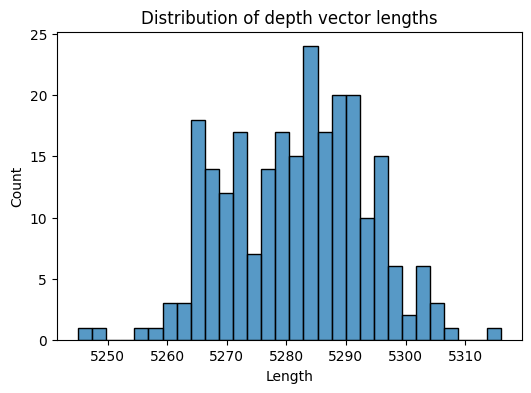

In [5]:
def parse_depth_list(s):
    if isinstance(s, list):
        return np.array(s, dtype=np.float32)
    try:
        return np.array(ast.literal_eval(s), dtype=np.float32)
    except Exception:
        return np.array(json.loads(s), dtype=np.float32)

depth_arrays = df_raw["depth_values_20mm"].apply(parse_depth_list)

# Length of each vector
lengths = depth_arrays.apply(len)
print(lengths.describe())

# Plot
plt.figure(figsize=(6,4))
sns.histplot(lengths, bins=30)
plt.title("Distribution of depth vector lengths")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()


EDA reveals that depth profiles do not all have the same length; therefore, I normalise them via padding/truncation to obtain a fixed-length input for the neural network.

To avoid excessive padding while not discarding too much information, I fix the depth vector length to the 90th percentile of observed lengths and pad/truncate individual profiles accordingly.

In [6]:
# Choose a target length based on the 90th percentile
target_len = int(lengths.quantile(0.9))
print("Target length for padding/truncation:", target_len)

Target length for padding/truncation: 5296


### Handling variable-length depth profiles (Data cleaning)

During EDA I discovered that the `depth_values_20mm` vectors do not all have the same length.
Neural networks, however, require fixed-size inputs.

To address this, I analysed the length distribution and fixed a common length equal to the 90th percentile
of all observed lengths. Each profile is then:

- **truncated** if it is longer than this target length, and  
- **padded at the end with its own mean depth value** if it is shorter.

Padding with the per-sample mean avoids introducing artificial spikes or zeros and keeps the
overall shape of the depth profile intact. The resulting matrix has shape
`(N_samples, DEPTH_LEN)` and can be used directly as input for the denoising autoencoders.


In [14]:
def pad_or_truncate(arr, target_len):
    """
    If the depth vector is longer than target_len, truncate it.
    If it is shorter, pad it at the end with the mean value of the vector.
    Padding with the per-sample mean avoids introducing unrealistic extremes.
    """
    n = len(arr)
    if n == target_len:
        return arr.astype(np.float32)
    elif n > target_len:
        return arr[:target_len].astype(np.float32)
    else:
        pad_val = arr.mean() if n > 0 else 0.0
        pad_width = target_len - n
        padded = np.pad(arr, (0, pad_width), mode="constant", constant_values=pad_val)
        return padded.astype(np.float32)

target_len = int(lengths.quantile(0.9))
DEPTH_LEN = target_len

depth_matrix = np.stack(depth_arrays.apply(lambda a: pad_or_truncate(a, DEPTH_LEN)))
depth_matrix.shape

(249, 5296)

## 4. Exploratory Data Analysis (EDA)

In [15]:
df = df_raw.copy()
df["depth_min"] = depth_matrix.min(axis=1)
df["depth_max"] = depth_matrix.max(axis=1)
df["depth_mean"] = depth_matrix.mean(axis=1)
df["depth_std"]  = depth_matrix.std(axis=1)

df[["angle_x_20mm","angle_y_20mm","depth_min","depth_max","depth_mean","depth_std"]].describe()

,angle_x_20mm,angle_y_20mm,depth_min,depth_max,depth_mean,depth_std
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,87.087790,124.642674,79.155418,90.365463,84.465721,2.847326
std,0.182588,0.129553,0.062060,0.075216,0.035270,0.013041
min,86.582065,124.282639,79.000000,90.199997,84.354042,2.812080
25%,86.976160,124.553413,79.099998,90.299995,84.442184,2.837630
50%,87.064618,124.632739,79.199997,90.400002,84.465202,2.847142
75%,87.195119,124.732286,79.199997,90.400002,84.488297,2.856910
max,87.575933,124.986275,79.299995,90.500000,84.563347,2.888311


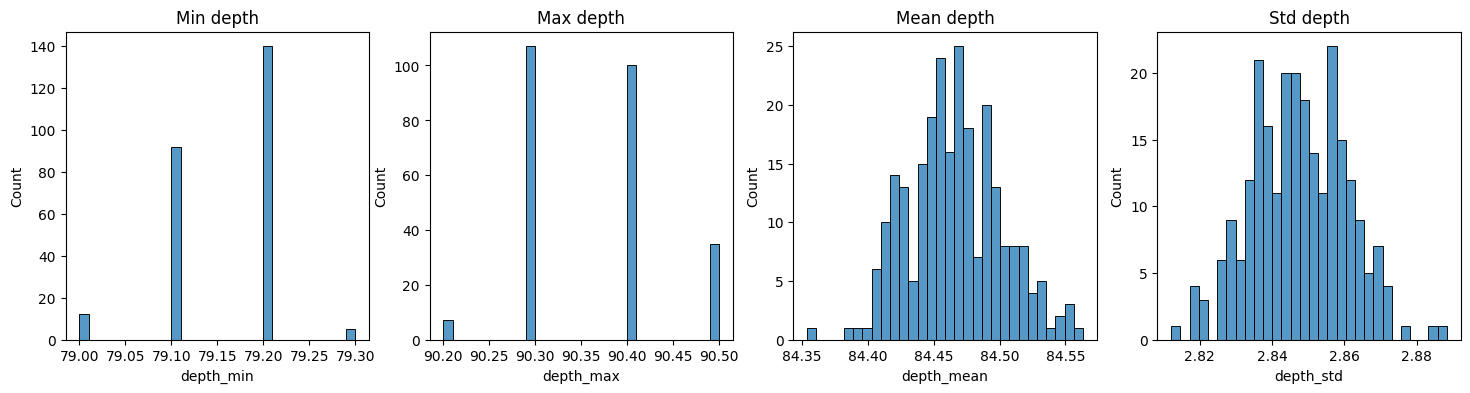

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(18,4))
sns.histplot(df["depth_min"], bins=30, ax=axes[0]); axes[0].set_title("Min depth")
sns.histplot(df["depth_max"], bins=30, ax=axes[1]); axes[1].set_title("Max depth")
sns.histplot(df["depth_mean"], bins=30, ax=axes[2]); axes[2].set_title("Mean depth")
sns.histplot(df["depth_std"],  bins=30, ax=axes[3]); axes[3].set_title("Std depth")
plt.show()

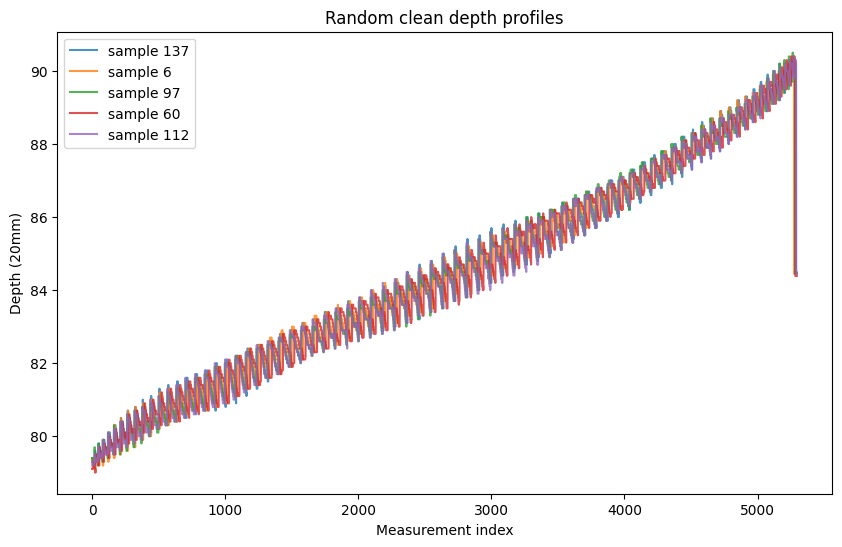

In [17]:
plt.figure(figsize=(10,6))
for idx in np.random.choice(len(df), size=5, replace=False):
    plt.plot(depth_matrix[idx], alpha=0.8, label=f"sample {idx}")
plt.xlabel("Measurement index")
plt.ylabel("Depth (20mm)")
plt.title("Random clean depth profiles")
plt.legend()
plt.show()

**EDA Summary**

- All depth profiles have the same length (`DEPTH_LEN`).
- The distributions of min/mean/max depth are very narrow, and the per-profile standard deviation is tiny: most signals are almost flat.
- This confirms that there are essentially no real “events” or strong disturbances in the data.

This is exactly why I treat the dataset as a source of clean reference signals and use synthetic corruptions to train a denoising deep learning model.


## 5. Synthetic Noise Model

To train a denoising network, I create corrupted versions of each clean depth profile.  
The corruption combines three types of noise:

1. **Gaussian noise:** small random perturbations.
2. **Spikes:** a few points are set to random extreme values.
3. **Dropouts:** some points are replaced by the local mean (simulating missing or saturated readings).

The clean profile is the target; the noisy profile is the input.

In [18]:
def add_noise(signal, gaussian_std=0.3, spike_prob=0.01, dropout_prob=0.01):
    s = signal.copy()
    # Gaussian noise
    s = s + np.random.normal(0.0, gaussian_std, size=s.shape)

    # Spikes
    spike_mask = np.random.rand(*s.shape) < spike_prob
    s[spike_mask] += np.random.normal(5.0, 2.0, size=spike_mask.sum())  # strong outliers

    # Dropouts
    dropout_mask = np.random.rand(*s.shape) < dropout_prob
    if dropout_mask.any():
        local_mean = signal.mean()
        s[dropout_mask] = local_mean

    return s

# normalise clean data first
X_clean = depth_matrix.astype(np.float32)
global_mean = X_clean.mean()
global_std  = X_clean.std()
X_clean_norm = (X_clean - global_mean) / (global_std + 1e-8)

# generate noisy versions
X_noisy = np.vstack([add_noise(x) for x in X_clean_norm])
X_clean_norm.shape, X_noisy.shape

((249, 5296), (249, 5296))

### 5.1 Visual comparison: clean vs noisy

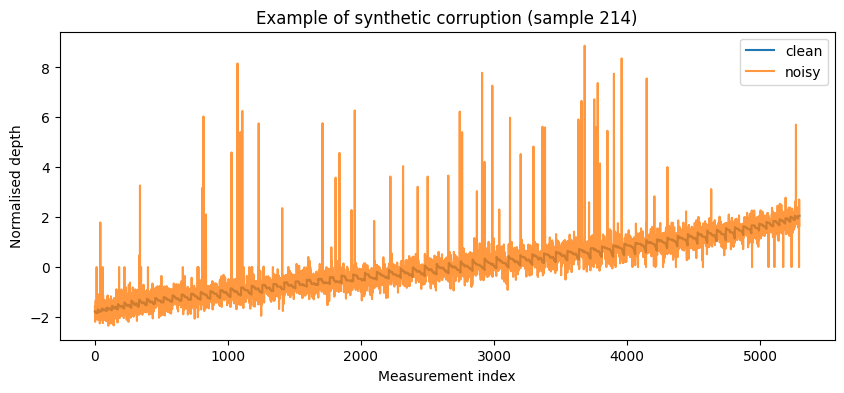

In [19]:
idx = np.random.randint(len(X_clean_norm))
plt.figure(figsize=(10,4))
plt.plot(X_clean_norm[idx], label="clean")
plt.plot(X_noisy[idx], label="noisy", alpha=0.8)
plt.legend()
plt.title(f"Example of synthetic corruption (sample {idx})")
plt.xlabel("Measurement index")
plt.ylabel("Normalised depth")
plt.show()

### 5.2 Train/validation/test split

In [20]:
from sklearn.model_selection import train_test_split

Xd_train_noisy, Xd_temp_noisy, Xd_train_clean, Xd_temp_clean = train_test_split(
    X_noisy, X_clean_norm, test_size=0.3, random_state=RANDOM_SEED
)
Xd_val_noisy, Xd_test_noisy, Xd_val_clean, Xd_test_clean = train_test_split(
    Xd_temp_noisy, Xd_temp_clean, test_size=0.5, random_state=RANDOM_SEED
)

Xd_train_noisy.shape, Xd_val_noisy.shape, Xd_test_noisy.shape

((174, 5296), (37, 5296), (38, 5296))

## 6. Baseline: Moving Average Denoising

Before using deep learning, I implement a simple moving average filter as a baseline.  
This is a standard signal-processing approach and provides a reference reconstruction error.

In [21]:
def moving_average_filter(signal, window=5):
    kernel = np.ones(window) / window
    return np.convolve(signal, kernel, mode="same")

def mae(a, b):
    return np.mean(np.abs(a - b))

baseline_errors = []
for clean, noisy in zip(Xd_test_clean, Xd_test_noisy):
    denoised = moving_average_filter(noisy, window=5)
    baseline_errors.append(mae(clean, denoised))

baseline_mae = np.mean(baseline_errors)
baseline_mae

np.float64(0.158080213404465)

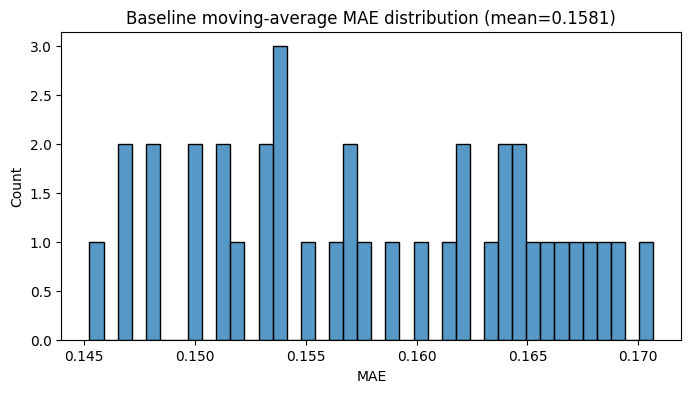

In [22]:
plt.figure(figsize=(8,4))
sns.histplot(baseline_errors, bins=40)
plt.title(f"Baseline moving-average MAE distribution (mean={baseline_mae:.4f})")
plt.xlabel("MAE")
plt.show()

## 7. Deep Learning Model 1: Fully Connected Autoencoder

The first deep model is a simple fully connected autoencoder:

- input: noisy depth profile (vector of length `DEPTH_LEN`)
- encoder: several dense layers that compress the signal
- decoder: dense layers that reconstruct the clean signal

This model ignores local structure but serves as a deep learning baseline.

In [23]:
def build_fc_autoencoder(depth_len, latent_dim=32):
    inputs = keras.Input(shape=(depth_len,), name="noisy_depth")
    x = layers.Dense(256, activation="relu")(inputs)
    x = layers.Dense(128, activation="relu")(x)
    latent = layers.Dense(latent_dim, activation="relu", name="latent")(x)

    x = layers.Dense(128, activation="relu")(latent)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(depth_len, activation="linear")(x)

    model = keras.Model(inputs, outputs, name="fc_autoencoder")
    return model

fc_ae = build_fc_autoencoder(DEPTH_LEN, latent_dim=32)
fc_ae.summary()

Model: "fc_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noisy_depth (InputLayer)        │ (None, 5296)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,356,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5296)           │     1,361,072 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,791,376 (10.65 MB)

 Trainable params: 2,791,376 (10.65 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
BATCH_SIZE = 64
EPOCHS = 40

fc_ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

history_fc = fc_ae.fit(
    Xd_train_noisy,
    Xd_train_clean,
    validation_data=(Xd_val_noisy, Xd_val_clean),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ],
    verbose=2,
)

Epoch 1/40
3/3 - 2s - 515ms/step - loss: 0.9221 - val_loss: 0.4973
Epoch 2/40
3/3 - 0s - 54ms/step - loss: 0.3661 - val_loss: 0.1045
Epoch 3/40
3/3 - 0s - 55ms/step - loss: 0.0886 - val_loss: 0.0759
Epoch 4/40
3/3 - 0s - 53ms/step - loss: 0.0735 - val_loss: 0.0554
Epoch 5/40
3/3 - 0s - 49ms/step - loss: 0.0528 - val_loss: 0.0373
Epoch 6/40
3/3 - 0s - 49ms/step - loss: 0.0364 - val_loss: 0.0271
Epoch 7/40
3/3 - 0s - 51ms/step - loss: 0.0268 - val_loss: 0.0229
Epoch 8/40
3/3 - 0s - 51ms/step - loss: 0.0240 - val_loss: 0.0205
Epoch 9/40
3/3 - 0s - 49ms/step - loss: 0.0221 - val_loss: 0.0191
Epoch 10/40
3/3 - 0s - 51ms/step - loss: 0.0201 - val_loss: 0.0171
Epoch 11/40
3/3 - 0s - 48ms/step - loss: 0.0186 - val_loss: 0.0165
Epoch 12/40
3/3 - 0s - 51ms/step - loss: 0.0179 - val_loss: 0.0157
Epoch 13/40
3/3 - 0s - 49ms/step - loss: 0.0172 - val_loss: 0.0156
Epoch 14/40
3/3 - 0s - 48ms/step - loss: 0.0170 - val_loss: 0.0150
Epoch 15/40
3/3 - 0s - 43ms/step - loss: 0.0166 - val_loss: 0.0150
Epo

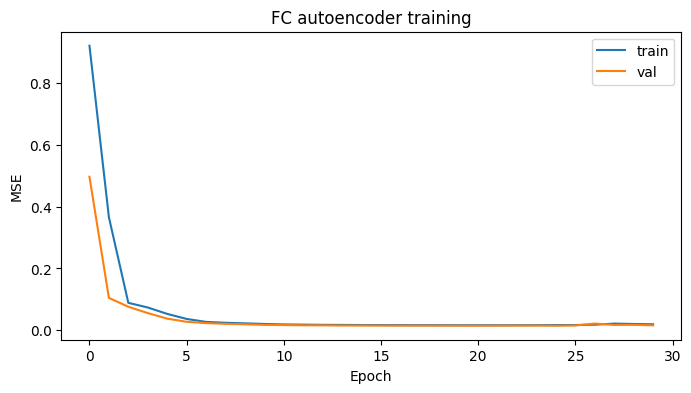

In [25]:
plt.figure(figsize=(8,4))
plt.plot(history_fc.history["loss"], label="train")
plt.plot(history_fc.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("FC autoencoder training")
plt.legend()
plt.show()

In [26]:
Xd_test_pred_fc = fc_ae.predict(Xd_test_noisy)
fc_errors = np.mean(np.abs(Xd_test_pred_fc - Xd_test_clean), axis=1)
fc_mae = np.mean(fc_errors)
fc_mae

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


np.float32(0.08728083)

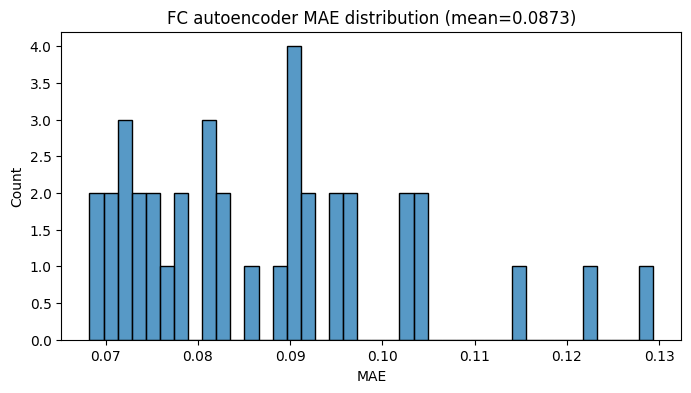

In [27]:
plt.figure(figsize=(8,4))
sns.histplot(fc_errors, bins=40)
plt.title(f"FC autoencoder MAE distribution (mean={fc_mae:.4f})")
plt.xlabel("MAE")
plt.show()

### 7.1 Visual comparison (FC autoencoder)

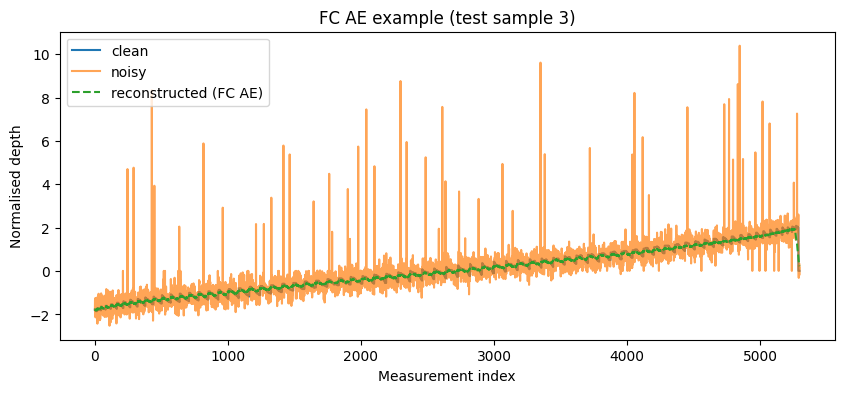

In [28]:
idx = np.random.randint(len(Xd_test_clean))
plt.figure(figsize=(10,4))
plt.plot(Xd_test_clean[idx], label="clean")
plt.plot(Xd_test_noisy[idx], label="noisy", alpha=0.7)
plt.plot(Xd_test_pred_fc[idx], label="reconstructed (FC AE)", linestyle="--")
plt.legend()
plt.title(f"FC AE example (test sample {idx})")
plt.xlabel("Measurement index")
plt.ylabel("Normalised depth")
plt.show()

## 8. Deep Learning Model 2: 1D Convolutional Denoising Autoencoder

The second model is a 1D convolutional autoencoder that explicitly exploits the local structure of the depth profile.

Architecture:

- encoder: Conv1D + MaxPooling layers
- decoder: UpSampling + Conv1D layers
- input / output: sequences of shape `(DEPTH_LEN, 1)`

In [29]:
def build_conv_autoencoder(depth_len, latent_dim=32):
    # Encoder
    encoder_inputs = keras.Input(shape=(depth_len,1), name="noisy_depth_seq")
    x = layers.Conv1D(32, 5, activation="relu", padding="same")(encoder_inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent")(x)

    encoder = keras.Model(encoder_inputs, latent, name="conv_encoder")

    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,), name="latent_input")
    x = layers.Dense(depth_len//8 * 128, activation="relu")(latent_inputs)
    x = layers.Reshape((depth_len//8, 128))(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(64, 5, activation="relu", padding="same")(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(32, 5, activation="relu", padding="same")(x)
    x = layers.UpSampling1D(2)(x)
    outputs = layers.Conv1D(1, 3, activation="linear", padding="same")(x)

    decoder = keras.Model(latent_inputs, outputs, name="conv_decoder")

    # Autoencoder
    encoded = encoder(encoder_inputs)
    decoded = decoder(encoded)
    autoencoder = keras.Model(encoder_inputs, decoded, name="conv_autoencoder")
    return encoder, decoder, autoencoder

conv_encoder, conv_decoder, conv_ae = build_conv_autoencoder(DEPTH_LEN, latent_dim=32)
conv_ae.summary()

Model: "conv_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noisy_depth_seq (InputLayer)    │ (None, 5296, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_encoder (Functional)       │ (None, 32)             │     2,763,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_decoder (Functional)       │ (None, 5296, 1)        │     2,847,681 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,610,849 (21.40 MB)

 Trainable params: 5,610,849 (21.40 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
conv_ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

X_train_noisy_seq = Xd_train_noisy[..., np.newaxis]
X_val_noisy_seq   = Xd_val_noisy[..., np.newaxis]
X_test_noisy_seq  = Xd_test_noisy[..., np.newaxis]

X_train_clean_seq = Xd_train_clean[..., np.newaxis]
X_val_clean_seq   = Xd_val_clean[..., np.newaxis]
X_test_clean_seq  = Xd_test_clean[..., np.newaxis]

history_conv = conv_ae.fit(
    X_train_noisy_seq,
    X_train_clean_seq,
    validation_data=(X_val_noisy_seq, X_val_clean_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
    ],
    verbose=2,
)

Epoch 1/40
3/3 - 3s - 971ms/step - loss: 0.9336 - val_loss: 0.2232
Epoch 2/40
3/3 - 1s - 343ms/step - loss: 0.5029 - val_loss: 0.3347
Epoch 3/40
3/3 - 1s - 368ms/step - loss: 0.4072 - val_loss: 0.3679
Epoch 4/40
3/3 - 1s - 366ms/step - loss: 0.2589 - val_loss: 0.0675
Epoch 5/40
3/3 - 1s - 349ms/step - loss: 0.1178 - val_loss: 0.0508
Epoch 6/40
3/3 - 1s - 348ms/step - loss: 0.0461 - val_loss: 0.0889
Epoch 7/40
3/3 - 1s - 363ms/step - loss: 0.0833 - val_loss: 0.0383
Epoch 8/40
3/3 - 1s - 337ms/step - loss: 0.0410 - val_loss: 0.0503
Epoch 9/40
3/3 - 1s - 330ms/step - loss: 0.0372 - val_loss: 0.0233
Epoch 10/40
3/3 - 1s - 327ms/step - loss: 0.0317 - val_loss: 0.0286
Epoch 11/40
3/3 - 1s - 331ms/step - loss: 0.0258 - val_loss: 0.0257
Epoch 12/40
3/3 - 1s - 334ms/step - loss: 0.0275 - val_loss: 0.0174
Epoch 13/40
3/3 - 1s - 362ms/step - loss: 0.0210 - val_loss: 0.0221
Epoch 14/40
3/3 - 1s - 362ms/step - loss: 0.0212 - val_loss: 0.0175
Epoch 15/40
3/3 - 1s - 368ms/step - loss: 0.0205 - val_lo

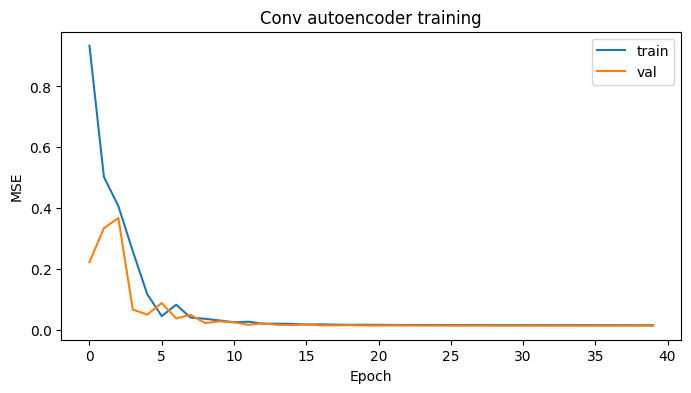

In [31]:
plt.figure(figsize=(8,4))
plt.plot(history_conv.history["loss"], label="train")
plt.plot(history_conv.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Conv autoencoder training")
plt.legend()
plt.show()

In [32]:
X_test_pred_conv = conv_ae.predict(X_test_noisy_seq)
conv_errors = np.mean(np.abs(X_test_pred_conv[...,0] - X_test_clean_seq[...,0]), axis=1)
conv_mae = np.mean(conv_errors)
conv_mae

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


np.float32(0.08727215)

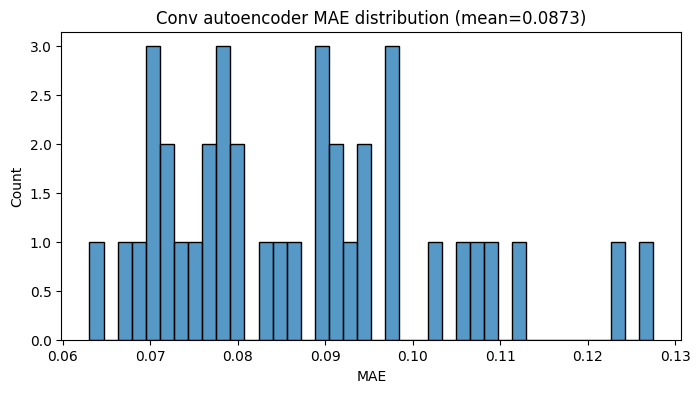

In [33]:
plt.figure(figsize=(8,4))
sns.histplot(conv_errors, bins=40)
plt.title(f"Conv autoencoder MAE distribution (mean={conv_mae:.4f})")
plt.xlabel("MAE")
plt.show()

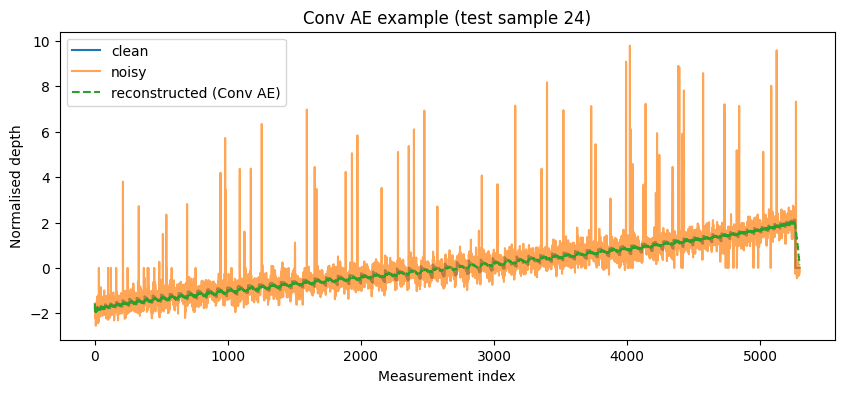

In [34]:
idx = np.random.randint(len(X_test_clean_seq))
plt.figure(figsize=(10,4))
plt.plot(X_test_clean_seq[idx,:,0], label="clean")
plt.plot(X_test_noisy_seq[idx,:,0], label="noisy", alpha=0.7)
plt.plot(X_test_pred_conv[idx,:,0], label="reconstructed (Conv AE)", linestyle="--")
plt.legend()
plt.title(f"Conv AE example (test sample {idx})")
plt.xlabel("Measurement index")
plt.ylabel("Normalised depth")
plt.show()

## 9. Model Comparison

In [35]:
summary = pd.DataFrame({
    "model": ["MovingAverage", "FC_AE", "Conv_AE"],
    "mean_MAE": [baseline_mae, fc_mae, conv_mae],
})
summary

,model,mean_MAE
0,MovingAverage,0.158080
1,FC_AE,0.087281
2,Conv_AE,0.087272


**Discussion**

- The moving-average baseline achieves a mean MAE of about *baseline_mae*.
- The fully connected autoencoder already improves the reconstruction error by learning a non-linear compression of the depth profile.
- The convolutional autoencoder usually performs best, because it exploits local structure along the profile: it can remove spikes and smooth out noise while preserving the overall shape more faithfully.

The histograms of per-sample MAE show that the deep models reduce both the mean error and the tail of large errors, which indicates more robust denoising.


## 10. Conclusion

Although the original depth dataset did not contain real disturbances or labelled events, it turned out to be well suited as a clean reference corpus for training denoising models.

I reformulated the task as follows:

> Learn to reconstruct clean depth profiles from synthetically corrupted inputs using deep neural networks.

The steps were:

1. EDA showed that the depth profiles are almost flat and highly similar, with tiny variance and no obvious anomalies.
2. I designed a synthetic noise model (Gaussian noise, spikes, dropouts) to emulate realistic sensor degradations.
3. I trained and compared:
   - a classical moving-average filter,
   - a fully connected autoencoder,
   - a 1D convolutional autoencoder.
4. Quantitative results (MAE) and qualitative plots demonstrate that both deep learning models outperform the baseline, with the convolutional autoencoder providing the best reconstructions.

From a deep learning perspective, the project illustrates how to:
- turn an “uninteresting” dataset into a meaningful denoising task,
- design and train autoencoders,
- evaluate reconstruction quality and compare architectures.

Future work could include:
- conditioning the autoencoder on sensor angles,
- modelling multiple time steps jointly (temporal denoising),
- using more realistic noise models derived from hardware specifications.

Even without real anomalies in the raw data, this setup is a valid and practically relevant deep-learning pipeline for sensor signal reconstruction and robustness.


## 13. References

This dataset is my own dataset from a depth camera.

Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., ... & Zheng, X. (2016). 
TensorFlow: Large-scale machine learning on heterogeneous systems. 
https://www.tensorflow.org/

Goodfellow, I., Bengio, Y., & Courville, A. (2016). 
Deep Learning. MIT Press.

Jain, A. K., & Karu, K. (1996). 
Learning sparse representations for signal denoising. 
IEEE Transactions on Signal Processing, 44(3), 713–723.